In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
root_folder = 'FC_AAE_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [5]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((100, prior_size)).to(device)
fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)

cpu


In [7]:
data, label = next(iter(train_loader))

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [9]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [10]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [11]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [15]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)

        fake_pred = Disc(Enc(data))
        true_pred = Disc(z)

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        
        latent = Enc(data)
        reconstructed = Dec(latent).view(-1, 1, 28, 28)
        fake_pred = Disc(latent)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [17]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
            z = torch.randn((batch_size, prior_size)).to(device)
            latent = Enc(data)
            reconstructed = Dec(latent).view(-1, 1, 28, 28)
            fake_pred = Disc(latent)
            true_pred = Disc(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        fixed_gen = Dec(fixed_z).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec(Enc(fixed_data)).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.8474, AE: 0.2809, D: 1.5925
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 0.6020, AE: 0.2630, D: 1.0230
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 1.3950, AE: 0.2610, D: 0.8955


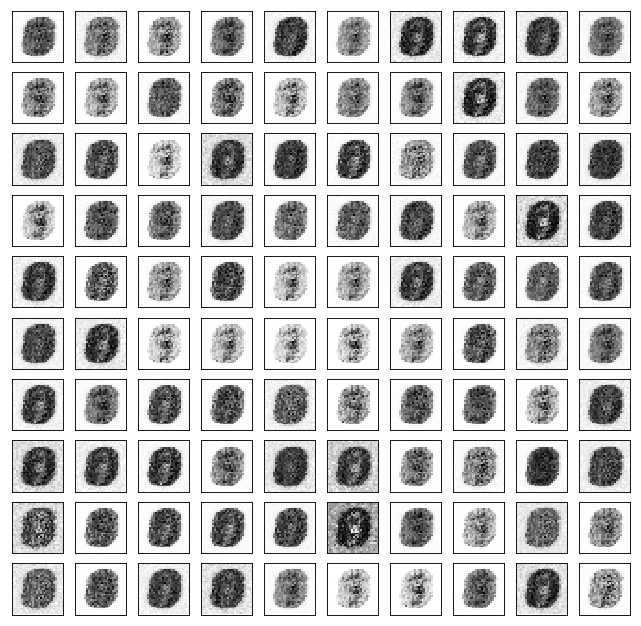

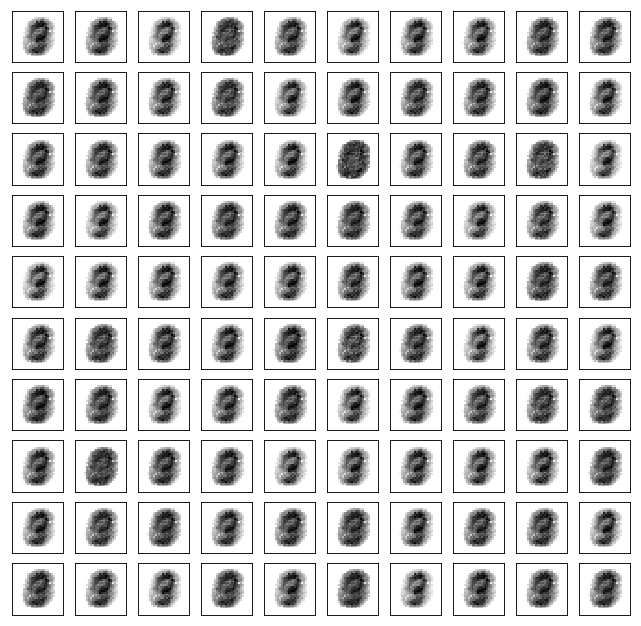

Test losses. E: 0.9947, AE: 0.2621, D: 0.9088
Train Epoch: 2 [0/50000 (0%)]	Losses E: 1.4547, AE: 0.2683, D: 0.9112
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.5612, AE: 0.2686, D: 0.8969
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 0.5144, AE: 0.2632, D: 0.7860


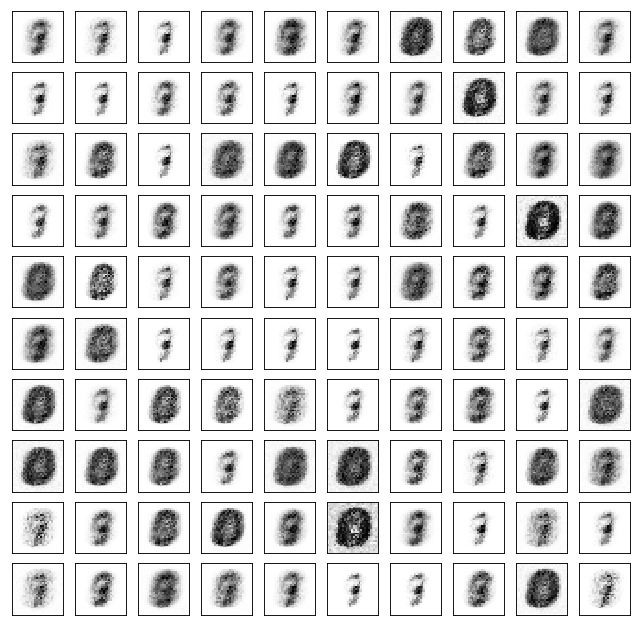

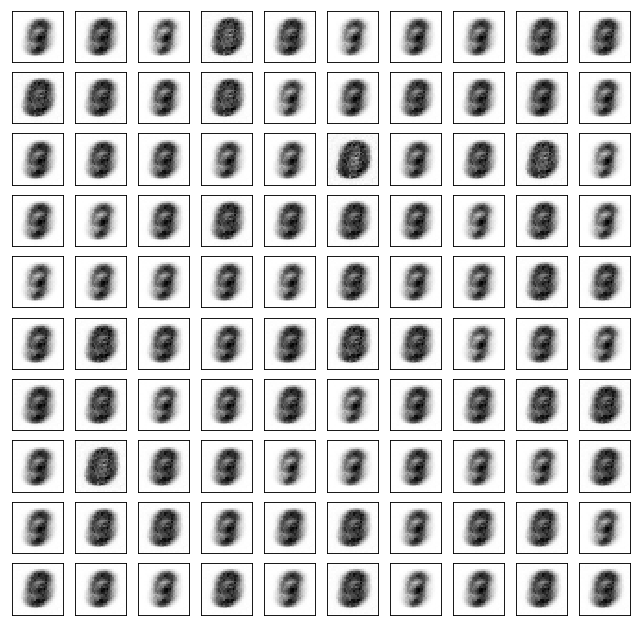

Test losses. E: 0.4794, AE: 0.2545, D: 0.7870
Train Epoch: 3 [0/50000 (0%)]	Losses E: 0.5104, AE: 0.2541, D: 0.7816
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.8152, AE: 0.2552, D: 0.8417
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5747, AE: 0.2478, D: 0.8130


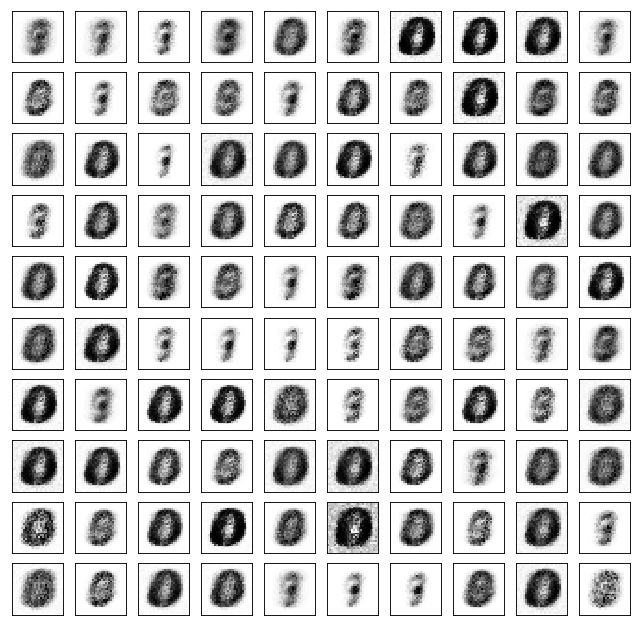

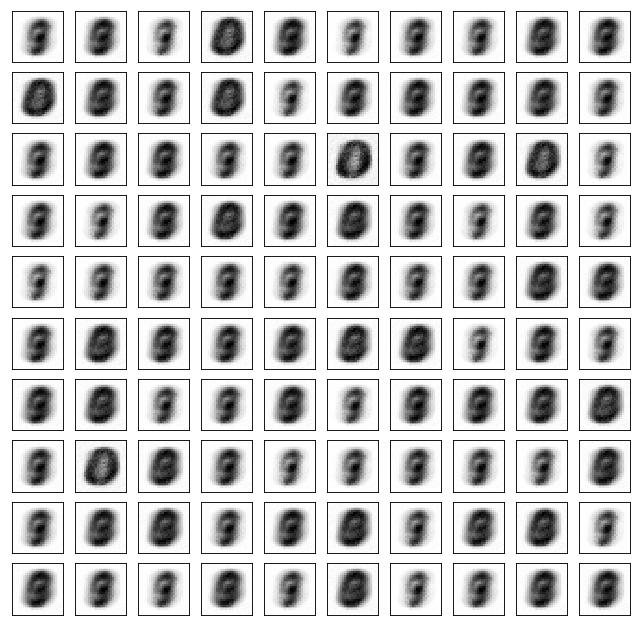

Test losses. E: 0.5668, AE: 0.2490, D: 0.7990
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5777, AE: 0.2550, D: 0.7968
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.6368, AE: 0.2464, D: 0.7266
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.6552, AE: 0.2393, D: 0.7918


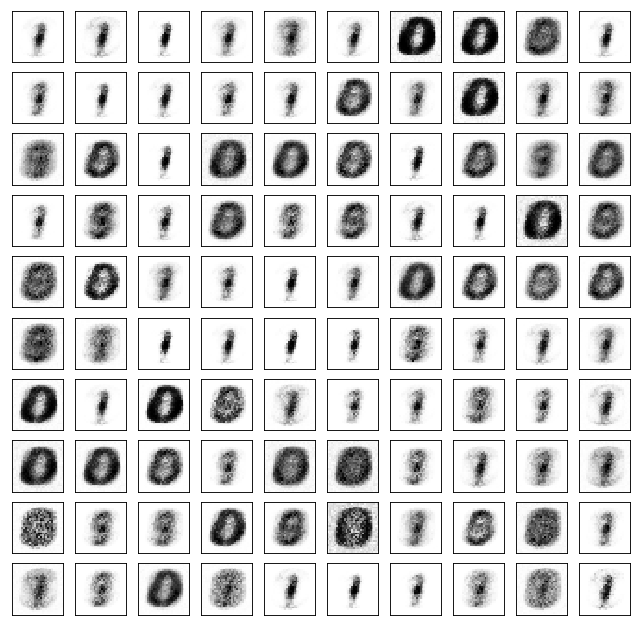

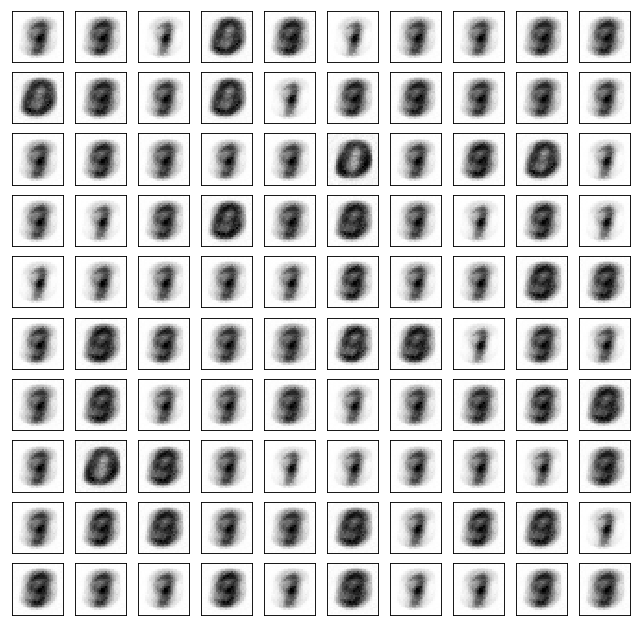

Test losses. E: 0.6330, AE: 0.2456, D: 0.7977
Train Epoch: 5 [0/50000 (0%)]	Losses E: 0.6482, AE: 0.2438, D: 0.7976
Train Epoch: 5 [25000/50000 (50%)]	Losses E: 0.6369, AE: 0.2409, D: 0.7200
Train Epoch: 5 [50000/50000 (100%)]	Losses E: 0.8457, AE: 0.2455, D: 0.6322


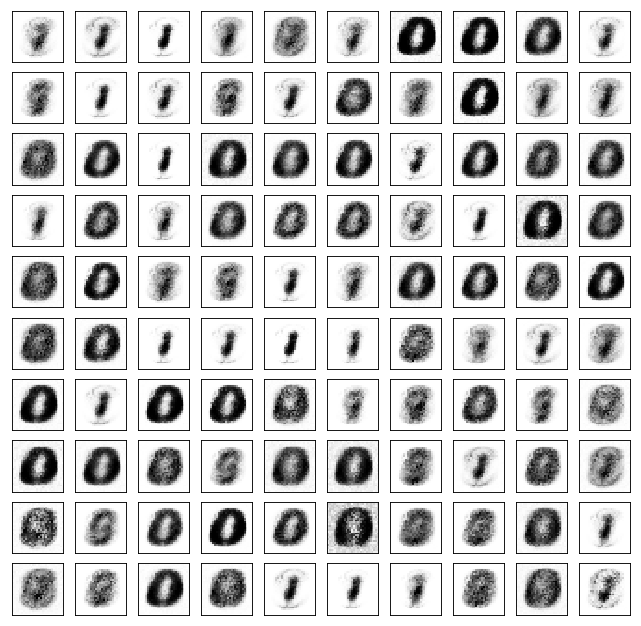

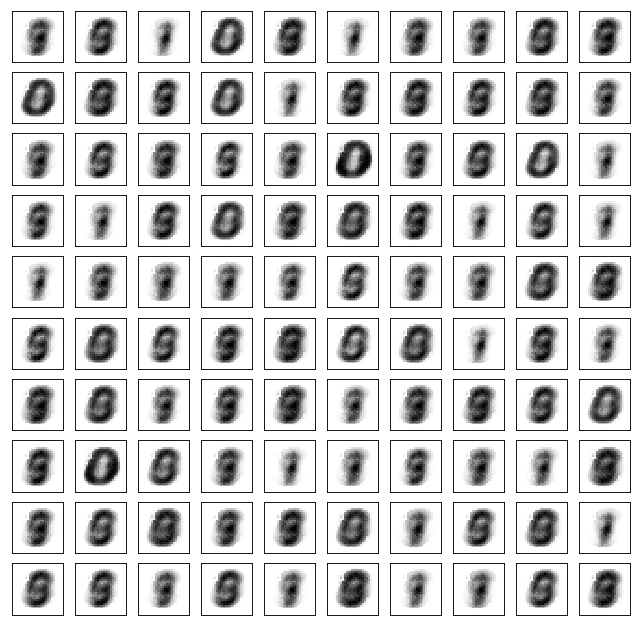

Test losses. E: 0.8138, AE: 0.2429, D: 0.6168
Train Epoch: 6 [0/50000 (0%)]	Losses E: 0.8537, AE: 0.2402, D: 0.6170
Train Epoch: 6 [25000/50000 (50%)]	Losses E: 0.8823, AE: 0.2380, D: 0.6877
Train Epoch: 6 [50000/50000 (100%)]	Losses E: 0.6215, AE: 0.2321, D: 0.7440


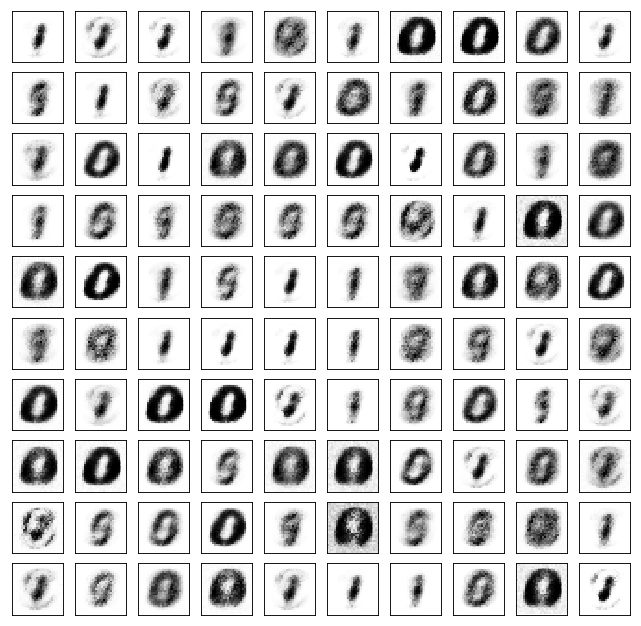

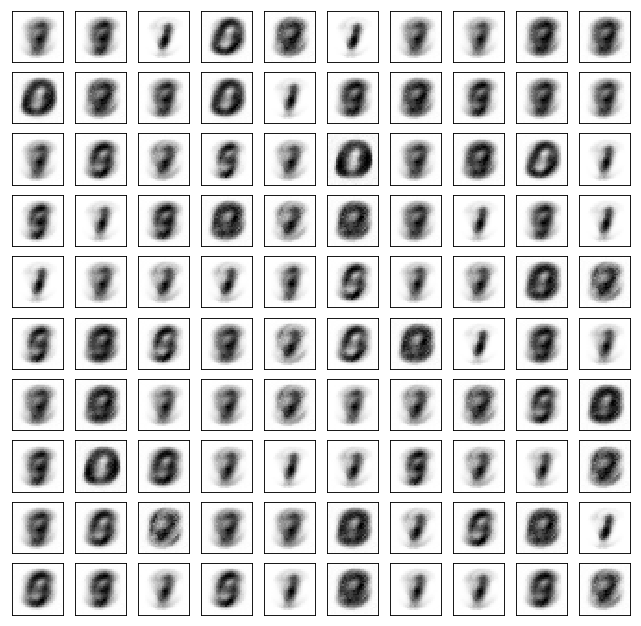

Test losses. E: 0.6185, AE: 0.2362, D: 0.7451
Train Epoch: 7 [0/50000 (0%)]	Losses E: 0.6212, AE: 0.2325, D: 0.7492
Train Epoch: 7 [25000/50000 (50%)]	Losses E: 0.6070, AE: 0.2277, D: 0.7511
Train Epoch: 7 [50000/50000 (100%)]	Losses E: 0.7170, AE: 0.2295, D: 0.7266


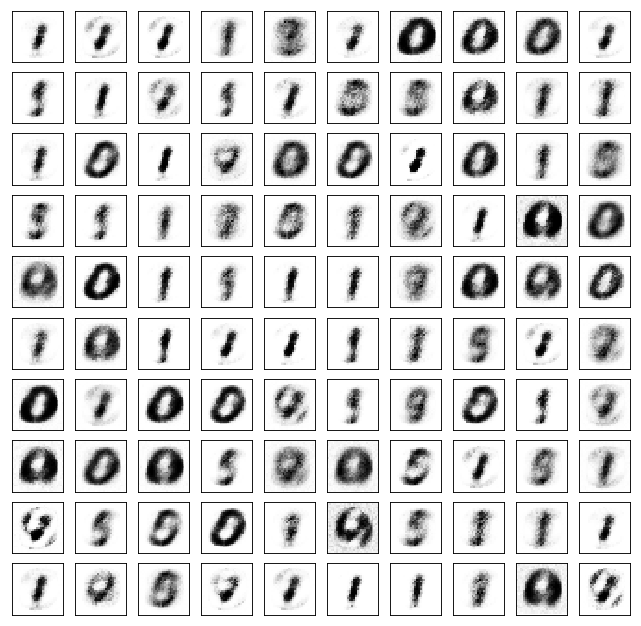

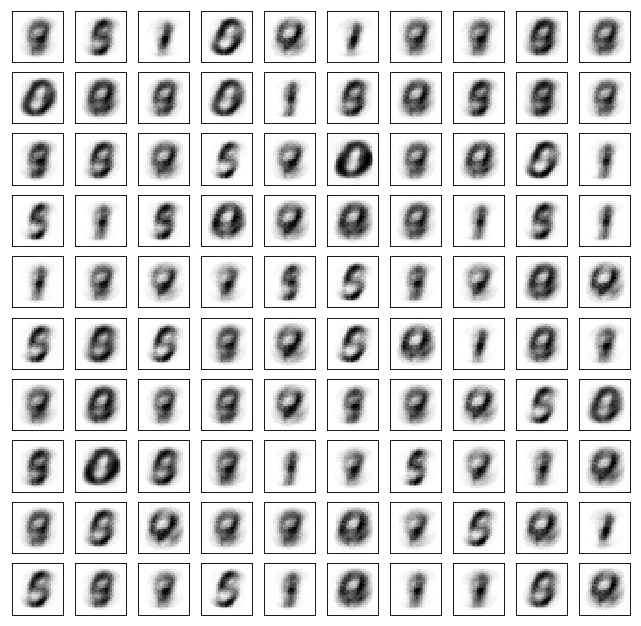

Test losses. E: 0.6998, AE: 0.2269, D: 0.7238
Train Epoch: 8 [0/50000 (0%)]	Losses E: 0.7183, AE: 0.2280, D: 0.7247
Train Epoch: 8 [25000/50000 (50%)]	Losses E: 0.7297, AE: 0.2188, D: 0.7336
Train Epoch: 8 [50000/50000 (100%)]	Losses E: 0.6318, AE: 0.2163, D: 0.7337


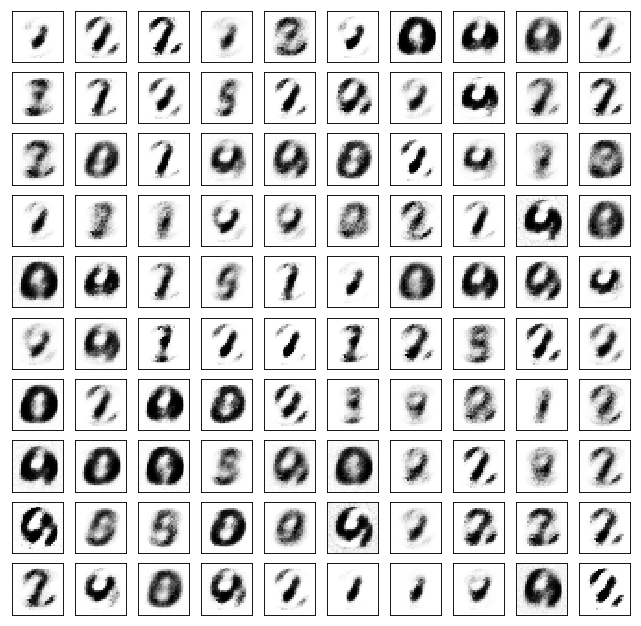

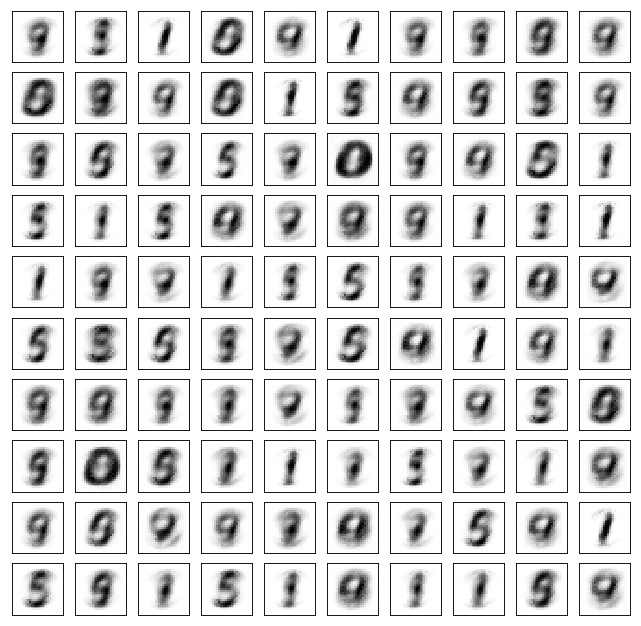

Test losses. E: 0.6303, AE: 0.2195, D: 0.7296
Train Epoch: 9 [0/50000 (0%)]	Losses E: 0.6364, AE: 0.2242, D: 0.7341


In [ ]:
for epoch in range(1, 1001):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)